# Imports

In [1]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import nn
import numpy as np
from functools import partial
import matplotlib.pyplot as plt 

# Constants

In [2]:
my_random_state = 42
BATCH_SIZE_default = 1024
eps_default = 1e-2
mode_default = 'l2'
lr_default = 1e-2

# Data generation and visualization

In [3]:
def gaussian_sampler_2d(gaussian_center, cov_matrix):
    mu_distr = MultivariateNormal(gaussian_center, cov_matrix)
    return mu_distr

def gaussian_data_sampling(gaussian_center, cov_matrix, data_num):
    sampler = gaussian_sampler_2d(gaussian_center, cov_matrix)
    data = sampler.sample(sample_shape=torch.Size([data_num]))
    return data
    
def plot_data_gaussians(data_mu, data_nu):
    fig = plt.figure(figsize=(10,10))

    plt.xlabel(r'$x$') 
    plt.ylabel(r'$y$') 
    plt.title('1 and 8 gaussians') 

    plt.scatter(data_mu[:, 0], data_mu[:, 1], label = r'$\mu$-s gaussian', marker='+')
    plt.scatter(data_nu[:, 0], data_nu[:, 1], label = r'$\nu$-s gaussians', marker='+', color = 'r')

    plt.legend()
    plt.grid(True) 

def gaussian_data_sampling_nu(centers_nu, cov_matrix, BATCH_SIZE, random_state):
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    index_to_choice = np.random.randint(centers_nu.shape[0], size = BATCH_SIZE)
    data_nu = gaussian_data_sampling(centers_nu[index_to_choice[0]], cov_matrix, 1)
    for i in range(1, BATCH_SIZE):
        cur_data_nu = gaussian_data_sampling(centers_nu[index_to_choice[i]], cov_matrix, 1)
        data_nu = torch.cat((data_nu, cur_data_nu), 0)
        
    return data_nu

def gaussian_data_sampling_mu(center_mu, cov_matrix, BATCH_SIZE, random_state):
    torch.manual_seed(random_state)
    return gaussian_data_sampling(center_mu, cov_matrix, BATCH_SIZE)

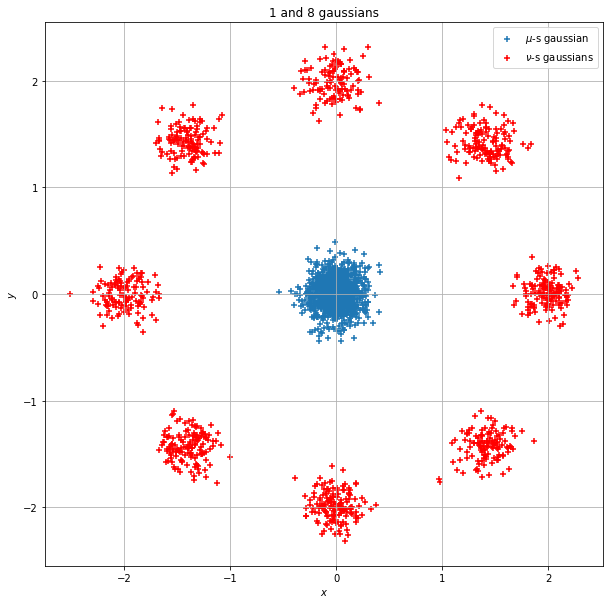

In [4]:
scale = 2.
nu_centers = [
            [1, 0],
            [-1, 0],
            [0, 1],
            [0, -1],
            [1./np.sqrt(2), 1./np.sqrt(2)],
            [1./np.sqrt(2), -1./np.sqrt(2)],
            [-1./np.sqrt(2), 1./np.sqrt(2)],
            [-1./np.sqrt(2), -1./np.sqrt(2)]
          ]
gaussian_num = len(nu_centers)
centers_nu_default = torch.Tensor([(scale*x,scale*y) for x,y in nu_centers])
center_mu_default = torch.zeros(2)
sigma = 0.02
init_cov_matrix = torch.eye(2)
cov_matrix_default = sigma*init_cov_matrix
#data_nu = data_generation(centers_nu[0], cov_matrix, data_num)
#data_num = 100
#for i in range(1, gaussian_num):
#    cur_data_nu = data_generation(centers_nu[i], cov_matrix, data_num)
#    data_nu = torch.cat((data_nu, cur_data_nu), 0)
data_nu = gaussian_data_sampling_nu(centers_nu_default, cov_matrix_default, BATCH_SIZE_default, my_random_state)

#data_mu_num = BATCH_SIZE // centers_nu.shape[0]
#data_mu = data_generation(center_mu, cov_matrix, data_mu_num)
data_mu = gaussian_data_sampling_mu(center_mu_default, cov_matrix_default, BATCH_SIZE_default, my_random_state)
plot_data_gaussians(data_mu.numpy(), data_nu.numpy())

# Neural nets for dual variables $u, v$

In [11]:
torch.manual_seed(my_random_state)
D_in = 2
D_out = 1
H = 100
u_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
v_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# Loss, its estimation and grads

In [12]:
def c_l2(x, y):
    return torch.dist(x, y, 2)**2

def F_eps(x, y, u_net_in_x, v_net_in_y, c = c_l2, eps=eps_default, mode=mode_default):
    res = torch.zeros(1)
    if mode == 'l2':
        relu = nn.ReLU()
        val = relu(u_net_in_x + v_net_in_y - c(x, y))
        res = -(val**2)/(4*eps)
    if mode == 'entropy':
        val = (u_net_in_x + v_net_in_y - c(x, y))/eps
        res = -eps*torch.exp(val)
    return res

def H_eps(x, y, u_net_in_x, v_net_in_y, c = c_l2, eps=eps_default, mode=mode_default):
    res = torch.zeros(1)
    if mode == 'l2':
        relu = nn.ReLU()
        val = relu(u_net_in_x + v_net_in_y - c(x, y))
        res = val/(2*eps)
    if mode == 'entropy':
        val = (u_net_in_x + v_net_in_y - c(x, y))/eps
        res = torch.exp(val)
    return res

def grad_F_eps(x, y, u_net_in_x, v_net_in_y, c = c_l2, eps=eps_default, mode=mode_default):
    return -H_eps(x, y, u_net_in_x, v_net_in_y, c, eps, mode)

def loss_estimation(u_net, v_net, data_mu, data_nu, c = c_l2, eps=eps_default, mode=mode_default):
    num_estimators = data_mu.shape[0]
    loss_estimators = []
    for i in range(num_estimators):
        u_net_in_x = u_net(data_mu[i])
        v_net_in_y = v_net(data_nu[i])
        cur_loss = u_net_in_x + v_net_in_y + F_eps(data_mu[i], data_nu[i], u_net_in_x, v_net_in_y) 
        loss_estimators.append(cur_loss)
    loss_estimators = torch.Tensor(loss_estimators)
    return torch.mean(loss_estimators)

In [13]:
x = data_mu[0]
y = data_mu[1]
u_net_in_x = u_net(x)
v_net_in_y = v_net(y)
c_test = c_l2(x, y)
print(f"Testing c_l2 function: c({x}, {y}) = {c_test}")
F_eps_test = F_eps(x, y, u_net_in_x, v_net_in_y)
grad_F_eps_test = grad_F_eps(x, y, u_net_in_x, v_net_in_y)
x = x.detach().numpy()
y = y.detach().numpy()
u_net_in_x = u_net_in_x.detach().numpy()
v_net_in_y = v_net_in_y.detach().numpy()
F_eps_test = F_eps_test.detach().numpy()
grad_F_eps_test = grad_F_eps_test.detach().numpy()

print(f"Testing F_eps function, eps = {eps_default}:")
print(f"F({x}, {y}, {u_net_in_x}, {v_net_in_y}) = {F_eps_test}")
print(f"Testing grad_F_eps function, eps = {eps_default}:")
print(f"grad_F_esp({x}, {y}, {u_net_in_x}, {v_net_in_y}) = {grad_F_eps_test}")

data_nu = gaussian_data_sampling_nu(centers_nu_default, cov_matrix_default, BATCH_SIZE_default, my_random_state)
data_mu = gaussian_data_sampling_mu(center_mu_default, cov_matrix_default, BATCH_SIZE_default, my_random_state)
loss = loss_estimation(u_net, v_net, data_mu, data_nu)
print(f"Testing loss_estimation function, eps = {eps_default}:")
loss = loss.detach().numpy()
print(f"loss = {loss}")

Testing c_l2 function: c(tensor([0.2725, 0.2103]), tensor([ 0.1274, -0.2978])) = 0.2792266011238098
Testing F_eps function, eps = 0.01:
F([0.27250695 0.21033372], [ 0.12738064 -0.2977656 ], [-0.14760509], [-0.23110077]) = [-0.]
Testing grad_F_eps function, eps = 0.01:
grad_F_esp([0.27250695 0.21033372], [ 0.12738064 -0.2977656 ], [-0.14760509], [-0.23110077]) = [-0.]
Testing loss_estimation function, eps = 0.01:
loss = -0.2577318549156189


# Training $u$ and $v$ nets using Algorithm 1

In [14]:
data_sampling_nu_default = partial(gaussian_data_sampling_nu, 
                                   centers_nu = centers_nu_default, cov_matrix = cov_matrix_default)
data_sampling_mu_default = partial(gaussian_data_sampling_mu, 
                                   center_mu = center_mu_default, cov_matrix = cov_matrix_default)

In [15]:
def stochastic_OT_computation(num_steps, random_states_arr, u_net, v_net, 
                              data_sampling_nu = data_sampling_nu_default,
                              data_sampling_mu = data_sampling_mu_default,
                              BATCH_SIZE = BATCH_SIZE_default, lr = lr_default, 
                              eps = eps_default, c = c_l2, mode=mode_default):
    loss_arr = []
    for num_step in range(num_steps):
        print(f"num_step = {num_step}")
        data_nu = data_sampling_nu(BATCH_SIZE = BATCH_SIZE, random_state = random_states_arr[num_step])
        data_mu = data_sampling_mu(BATCH_SIZE = BATCH_SIZE, random_state = random_states_arr[num_step])
        
        u_params_dict = {params_name: params for params_name, params in zip(u_net.state_dict(), 
                                                                         u_net.parameters())}
        v_params_dict = {params_name: params for params_name, params in zip(v_net.state_dict(), 
                                                                         v_net.parameters())}
        
        #u_upd_grad_dict = {params_name: torch.zeros_like(params.grad) 
        #                   for params_name, params in zip(u_net.state_dict(), u_net.parameters())}
        #v_upd_grad_dict = {params_name: torch.zeros_like(params.grad) 
        #                   for params_name, params in zip(v_net.state_dict(), v_net.parameters())}
        u_upd_grad_dict = u_params_dict
        v_upd_grad_dict = v_params_dict
        
        for i in range(BATCH_SIZE):
            for j in range(BATCH_SIZE):
                x = data_mu[i]
                y = data_nu[j]

                u_net.zero_grad()
                u_net_in_x = u_net(x)
                u_net_in_x.backward()

                v_net.zero_grad()
                v_net_in_y = v_net(y)
                v_net_in_y.backward()

                grad_F_eps_test = grad_F_eps(x, y, u_net_in_x, v_net_in_y, c = c, eps = eps, mode = mode)

                u_grad_dict = {params_name: params.grad*(1 +  grad_F_eps_test)*lr
                               for params_name, params in zip(u_net.state_dict(), u_net.parameters())}
                v_grad_dict = {params_name: params.grad*(1 +  grad_F_eps_test)*lr 
                               for params_name, params in zip(v_net.state_dict(), v_net.parameters())}

                for u_key in u_grad_dict.keys():
                    u_upd_grad_dict[u_key] = u_upd_grad_dict[u_key] + u_grad_dict[u_key]
                    
                for v_key in v_grad_dict.keys():
                    v_upd_grad_dict[v_key] = v_upd_grad_dict[v_key] + v_grad_dict[v_key]
        
        for params_name, params in u_net.state_dict().items():
            u_net.state_dict()[params_name].data.copy_(u_upd_grad_dict[params_name])
            
        for params_name, params in v_net.state_dict().items():
            v_net.state_dict()[params_name].data.copy_(v_upd_grad_dict[params_name])
            
        loss = loss_estimation(u_net, v_net, data_mu, data_nu, c = c, eps = eps, mode = mode)
        print(f"Loss estimation on sampled data = {loss.item()}")
        
        loss_arr.append(loss.item())
    
    return loss_arr

In [ ]:
num_steps = 50
random_states_arr = range(num_steps)
loss_history =  stochastic_OT_computation(num_steps, random_states_arr, u_net, v_net)

num_step = 0


In [9]:
z = {'a': 1, 'v': 2}
for key in z.keys():
    print(z[key])

1
2


In [104]:
params_generator = u_net.parameters()
a = next(params_generator)
b = next(params_generator)
c = next(params_generator)
d = next(params_generator)
print(a.shape, b.shape, c.shape, d.shape)

torch.Size([100, 2]) torch.Size([100]) torch.Size([1, 100]) torch.Size([1])


In [128]:
a.grad

tensor([[ 0.0000,  0.0000],
        [-0.0040,  0.0051],
        [-0.0035,  0.0045],
        [ 0.0000,  0.0000],
        [ 0.0104, -0.0134],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0028, -0.0036],
        [ 0.0083, -0.0107],
        [-0.0019,  0.0025],
        [ 0.0000,  0.0000],
        [-0.0067,  0.0086],
        [ 0.0000,  0.0000],
        [-0.0095,  0.0122],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0073, -0.0094],
        [-0.0088,  0.0113],
        [-0.0098,  0.0127],
        [-0.0018,  0.0024],
        [ 0.0000,  0.0000],
        [ 0.0091, -0.0117],
        [ 0.0000,  0.0000],
        [-0.0096,  0.0123],
        [-0.0005,  0.0007],
        [ 0.0028, -0.0037],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0

In [123]:
x = data_mu[0]
u_net.zero_grad()
s = u_net(x)
s.backward()

In [126]:
print(x.grad)

None


In [114]:
for param in u_net.parameters():

In [130]:
u_net.zero_grad()

In [131]:
params_generator = u_net.parameters()
a = next(params_generator)
print(a.grad)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

In [132]:
x = data_mu[0]
u_net.zero_grad()
s = u_net(x)
s.backward()

In [148]:
u_net.state_dict()['0.weight'].data.copy_(torch.zeros_like(u_net.state_dict()['0.weight']))

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

In [152]:
for layer_name, weights in u_net.state_dict().items():
    print(layer_name)

0.weight
0.bias
2.weight
2.bias


In [176]:
x = data_mu[0]
u_net.zero_grad()
s = u_net(x)
s.backward()

In [167]:
a = u_net.state_dict()['0.bias']

In [168]:
print(a)

tensor([-0.4969,  0.1448,  0.5181, -0.1398,  0.4304, -0.1503, -0.3365, -0.6471,
        -0.4738,  0.5308,  0.4763,  0.6823, -0.0713,  0.2390, -0.0868,  0.6999,
        -0.5638, -0.1920, -0.6780,  0.0698, -0.5505, -0.4959,  0.1635,  0.7035,
         0.5894,  0.4858, -0.1750, -0.0213, -0.6357,  0.4753,  0.1932,  0.6002,
        -0.6874, -0.1724, -0.4554, -0.5411, -0.4204,  0.2234,  0.4701,  0.3193,
        -0.2422,  0.3119,  0.6965,  0.0346, -0.2545, -0.5584,  0.4999, -0.1616,
        -0.5548,  0.4089,  0.1410, -0.2854, -0.6960,  0.0887, -0.2094, -0.1226,
        -0.2359,  0.5816,  0.3753,  0.5606,  0.2670,  0.2018,  0.6979, -0.0025,
         0.4065,  0.2875, -0.6767,  0.4804, -0.0693, -0.4775,  0.4765, -0.5727,
         0.3315, -0.5817, -0.2028, -0.6634,  0.5057,  0.1748,  0.5770,  0.2158,
        -0.3506,  0.1063,  0.4785, -0.5467, -0.4717, -0.1799, -0.4418, -0.1285,
         0.6696,  0.3932, -0.5733, -0.3816,  0.5675, -0.0542, -0.2977,  0.1382,
        -0.1123,  0.2382,  0.0130,  0.40

In [177]:
grad_dict = {k:v.grad for k, v in zip(u_net.state_dict(), u_net.parameters())}

In [178]:
grad_dict

{'0.weight': tensor([[ 0.0000e+00,  0.0000e+00],
         [-3.9610e-03,  5.0946e-03],
         [-3.4947e-03,  4.4949e-03],
         [ 0.0000e+00,  0.0000e+00],
         [ 1.0442e-02, -1.3430e-02],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 2.8194e-03, -3.6262e-03],
         [ 8.3434e-03, -1.0731e-02],
         [-1.9076e-03,  2.4535e-03],
         [ 0.0000e+00,  0.0000e+00],
         [-6.7028e-03,  8.6210e-03],
         [ 0.0000e+00,  0.0000e+00],
         [-9.4930e-03,  1.2210e-02],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [-2.0510e-03,  2.6380e-03],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 7.3432e-03, -9.4448e-03],
         [-8.8005e-03,  1.1319e-02],
         [-9.8407e-03,  1.2657e-02],
         [-1.8426e-03,  2.3699e-03],
         [ 0.0000e+00,  0.

In [173]:
u_net.zero_grad()